# Phys 581 Winter 2019
# Assignment #2: Geomagnetic Bottle
## Alexander Hickey, 10169582

In [1]:
#Import useful libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

### Introduction

The Earth's magnetic field, also known as the geomagnetic field, is wildly complex and is of great interest to space physicists. In particular, understanding how charged particles interact with the geomagnetic field is key to understanding how the Earth interacts with the solar wind.

To first order, the geomagnetic field can be approximated as a magnetic dipole. The magnetic field of a dipole in standard spherical coordinates is given by:

$$\mathbf B(\mathbf r) = \frac{\mu_0}{4\pi} \frac{M_E}{r^3} \left( 2\cos{\theta} \hat r  + \sin \theta \mathbf{\hat{\theta}} \right)$$

where $M_E = 8.05 \times 10^{22} \text{ Am}^2$ is the magnetic dipole moment of the earth, and $\mu_0= 4\pi \times 10^{-7} \text{ Tm/A}$ is the permeability of free space. Working with these numbers directly is generally not a great idea, as they are many orders of magnitude different, so we will attempt to make these numbers dimensionless. We will measure all distances in units of the radius of earth $R_E = 6371 \text{ km}$. Define a base unit of magnetic flux density

$$B_0 := \frac{\mu_0}{4 \pi} \frac{M_E}{R_E^3} = 3.113\times 10^{-5} \text{ T}$$

then we can rewrite the Earth's magnetic field as 

$$\mathbf B= B_0 \left(\frac{R_E}{r} \right)^3\left(2 \cos \theta \hat r + \sin \theta \hat \theta \right).$$

Using the standard spherical to cartesian transformation, we have

\begin{align}
r &= \sqrt{x^2+y^2+z^2}, \qquad \cos \theta = \frac{z}{\sqrt{x^2+y^2+z^2}}, \qquad \sin \theta = \sqrt{\frac{x^2+y^2}{x^2+y^2+z^2}} \\
\hat r &= \frac{1}{\sqrt{x^2+y^2+z^2}}\left(x\hat x + y \hat y + z \hat z \right), \qquad \hat \theta = \frac{1}{\sqrt{x^2+y^2+z^2}}\left(x\hat x + y \hat y + z \hat z \right) \\
\end{align}

so the dipole magnetic field in cartesian coordinates is 

$$\mathbf B= B_0 \frac{R_E^3}{(x^2+y^2+z^2)^{5/2}} \left[ 3xz \hat x + 3yz \hat y + \left( 2z^2-x^2-y^2 \right) \hat z \right].$$

A particle of charge $q$ will then experience a force governed by the Lorentz force law 

$$\mathbf F = q \mathbf v \times \mathbf B$$

In this notebook, we will consider the motion of a proton through the Earth's magnetic field. 

##### Task: 
Read  https://www2.mps.mpg.de/solar-system-school/lectures/space_plasma_physics_2007/Lecture_3.pdf and then numerically integrate the motion of a 1keV proton starting at the surface of the Earth ($r=6371km$) with latitude $66^\circ$ moving antiparallel to the local $\vec B$.  Assume the geomagnetic field is a dipole aligned with the spin axis with magnetic moment $M_E=8.05E22 A m^2$.

Does you result look like the plot in slide#7?  If not, what values (eg. energy, pitch angle, latitude) produce a better resemblance?

In [2]:
T = 1.60218e-16 #Kinetic energy in J
RE = 6371e3 #Radius of earth in m
Lat = 66 #Latitude in degrees
ME = 8.05e22 #Magnetic moment of earth in Am^2
m = 1.6726219e-27 #Proton mass in kg
mu0 = 1e-7 #Normalized permeability mu_0/4pi
e = 1.60217662e-19 #Elementary charge in Coulombs
B0 = mu0*ME/RE**3
v0 = np.sqrt(2*T/m)

In [11]:
def B(x,y,z):
    
    global B0,RE
    
    scale = B0*RE**3/(x*x+y*y+z*z)**(5/2)
    
    Bx = 3.0*x*z
    By = 3.0*y*z
    Bz = 2.0*z*z-x*x-y*y
    
    return np.array([Bx,By,Bz])*scale

def sphere_to_cart(rtp):
    
    xyz = np.zeros(rtp.shape)
    
    xyz[0] = rtp[0]*np.sin(rtp[1])*np.cos(rtp[2])
    xyz[1] = rtp[0]*np.sin(rtp[1])*np.sin(rtp[2])
    xyz[2] = rtp[0]*np.cos(rtp[1])
    
    return xyz

def time_evol(t,state):
    '''
    state = [vx,vy,vx,x,y,z]
    '''
    global v0,e,m

    newstate = np.zeros(state.shape)
    x,y,z = state[3:]
    vx,vy,vz = state[:3]
    #speed = np.sqrt(vx**2+vy**2+vz**2)
    vel = np.array([vx,vy,vz]) #*v0/speed
    
    newstate[:3] = e/m*np.cross(vel,B(x,y,z))
    
    newstate[3:] = state[:3]#*v0/speed
    
    
    return newstate

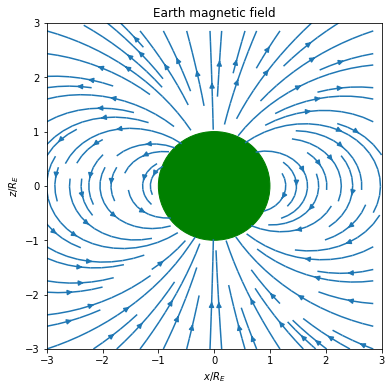

In [12]:
w = 3.0
x, y, z = np.linspace(-w,w,100),0 , np.linspace(-w,w,100)
xx,zz = np.meshgrid(x,z)
Bx, By, Bz = B(xx,y,zz)
mask = xx**2+zz**2 > 1

fig, ax = plt.subplots(figsize = (6,6))
ax.streamplot(x, z, Bx*mask, Bz*mask)
circ = plt.Circle((0, 0), radius=1, edgecolor='green', facecolor='green')
ax.add_patch(circ)
ax.set_xlabel('$x/R_E$')
ax.set_ylabel('$z/R_E$')
ax.set_title('Earth magnetic field')
plt.show()

Lat = 50, T = 1GEV, pitch 5x larger in z

In [13]:
#Initialize:
state0 = np.zeros(6)
r,theta,phi = RE,(90-Lat)*np.pi/180,0.0
x0,y0,z0 = sphere_to_cart(np.array([r,theta,phi]))
B0vec = B(x0,y0,z0)
v0vec = v0*B0vec/np.linalg.norm(B0vec)
state0[:3] = v0vec
state0[3:] = [x0, y0, z0]

t_span = (0,250)
#t_eval = np.linspace(0,100)
dat = scipy.integrate.solve_ivp(time_evol,t_span,state0)

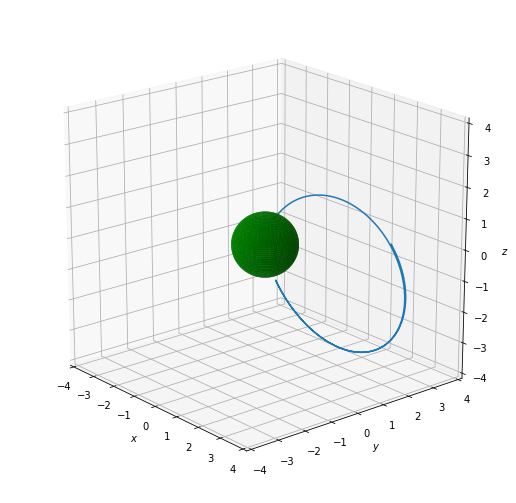

In [14]:
time = dat.t
[x,y,z] = dat.y[3:]/RE

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(9,9))
ax = fig.gca(projection='3d')
#ax = plt.axes(projection='3d')
ax.plot3D(x,y,z)

ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_zlim(-4, 4)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.view_init(20,-40)


u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
xc = 1. * np.outer(np.cos(u), np.sin(v))
yc = 1. * np.outer(np.sin(u), np.sin(v))
zc = 1. * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
ax.plot_surface(xc, yc, zc, color='g')

plt.show()

(0, 300)

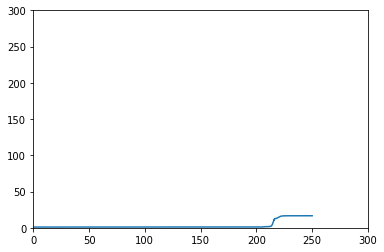

In [15]:
Tlist = m/2*(dat.y[0]**2+dat.y[1]**2+dat.y[2]**2)/T
plt.plot(dat.t,Tlist)

plt.ylim(0,300)
plt.xlim(0,300)